## Extracellular response of a passive cell to synaptic input: Plot Local Field

Adapted from LFPy Github  https://github.com/LFPy/LFPy/blob/master/examples/LFPy-example-03.ipynb

Modified by: Darshan Mandge, Open Brain Institute

Copyright (c) 2025 Open Brain Institute

The following notebook show the extracellular response of a synaptic input to a passive cADpyr neuron and show the local field lines

## Get the data
We can get the data using the entitysdk package. It has a function dedicated to download a SimulatableNeuron (also called MEModel). It will download a hoc file, a morphology and mechanisms (ion channel models).

To download the files, execute the following cell, and click on the link to set up authentication with the platform. If the code does not work, you might have to update the memodel_id, since it can change after a new deployment of the database.

In [1]:
from obi_auth import get_token
from entitysdk.client import Client
from entitysdk.downloaders.memodel import download_memodel
from entitysdk.models import MEModel


memodel_id = "59e584ec-5ab0-4e2c-a0c1-dab57a5e18b3"

token = get_token(environment="staging", auth_mode="daf")
client = Client(environment="staging", token_manager=token)

memodel = client.get_entity(
    entity_type=MEModel,
    entity_id=memodel_id,
)
downloaded_memodel = download_memodel(
    client, memodel=memodel
)

Please open url in a different tab:  https://staging.openbraininstitute.org/auth/realms/SBO/device?user_code=BPYH-XOXK


The local path to the output files can be fetched with the following cell. We can get the local hoc file path, the local morphology path, and the local mechanisms (i.e. the ion channel moddels) directory path.

In [2]:
hoc_file = downloaded_memodel.hoc_path
morph_file = downloaded_memodel.morphology_path
mechanisms_folder = downloaded_memodel.mechanisms_dir

Next you will have to compile the mechanisms.

In [4]:
!nrnivmodl {mechanisms_folder}

# Alternatively 
# import os
# os.system(f"{venv_path}/bin/nrnivmodl {mechanisms_folder}")

/Users/aurelien/venvs/venv-py312/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/aurelien/repos/obi_platform_analysis_notebooks/Cellular/emodels/lfpy_simulations/passive_emodel_synapses_LFP
Mod files: "mechanisms/mechanisms/CaDynamics_DC0.mod" "mechanisms/mechanisms/Ca_HVA2.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/NaTg.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [5]:
# Example plot for LFPy: Single-synapse contribution to the LFP

%matplotlib inline
import LFPy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

--No graphics will be displayed.


In [6]:
# Define cell parameters
cell_parameters = {
    'morphology' : str(morph_file), 
    'cm' : 1.0,         # membrane capacitance
    'Ra' : 150.0,       # axial resistance
    'v_init' : -65,     # initial crossmembrane potential
    'passive' : True,   # turn on NEURONs passive mechanism for all sections
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65},
    'nsegs_method' : 'lambda_f', # spatial discretization method
    'lambda_f' : 100.,           # frequency where length constants are computed
    'dt' : 2.**-3,      # simulation time step size
    'tstart' : 0.,      # start time of simulation, recorders start at t=0
    'tstop' : 100.,     # stop simulation at 100 ms.
}

# Create cell
cell = LFPy.Cell(**cell_parameters)
# Align cell
# cell.set_rotation(x=4.99, y=-4.33, z=3.14)
cell.set_rotation(x=4.98919, y=9.3, z=0)

In [7]:
# Define synapse parameters
synapse_parameters = {
    'idx' : cell.get_closest_idx(x=-200., y=0., z=800.),
    'e' : 0.,                   # reversal potential
    'syntype' : 'ExpSyn',       # synapse type
    'tau' : 5.,                 # synaptic time constant
    'weight' : .001,            # synaptic weight
    'record_current' : True,    # record synapse current
}

# Create synapse and set time of synaptic input
synapse = LFPy.Synapse(cell, **synapse_parameters)
synapse.set_spike_times(np.array([20.]))

In [8]:
# Run simulation, record transmembrane currents
cell.simulate(rec_imem=True)

In [9]:
# Create a grid of measurement locations, in (mum)
X, Z = np.mgrid[-700:701:50, -400:1201:50]
Y = np.zeros(X.shape)

# Define electrode parameters
grid_electrode_parameters = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

# Define electrode parameters
point_electrode_parameters = {
    'sigma' : 0.3,  # extracellular conductivity
    'x' : np.array([-130., -105.]),
    'y' : np.array([   0.,    0.]),
    'z' : np.array([   0.,  325.]),
}

    # 'x' : np.array([-130., -220.]),
    # 'y' : np.array([   0.,    0.]),
    # 'z' : np.array([   0.,  700.]),

# Create electrode objects
grid_electrode = LFPy.RecExtElectrode(cell, **grid_electrode_parameters)
point_electrode = LFPy.RecExtElectrode(cell, **point_electrode_parameters)

# Calculate LFPs as product between linear transform and currents. 
# Create reference to data on class object
grid_electrode.LFP = grid_electrode.get_transformation_matrix() @ cell.imem
point_electrode.LFP = point_electrode.get_transformation_matrix() @ cell.imem

## Plot simulation output:

[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, '')]

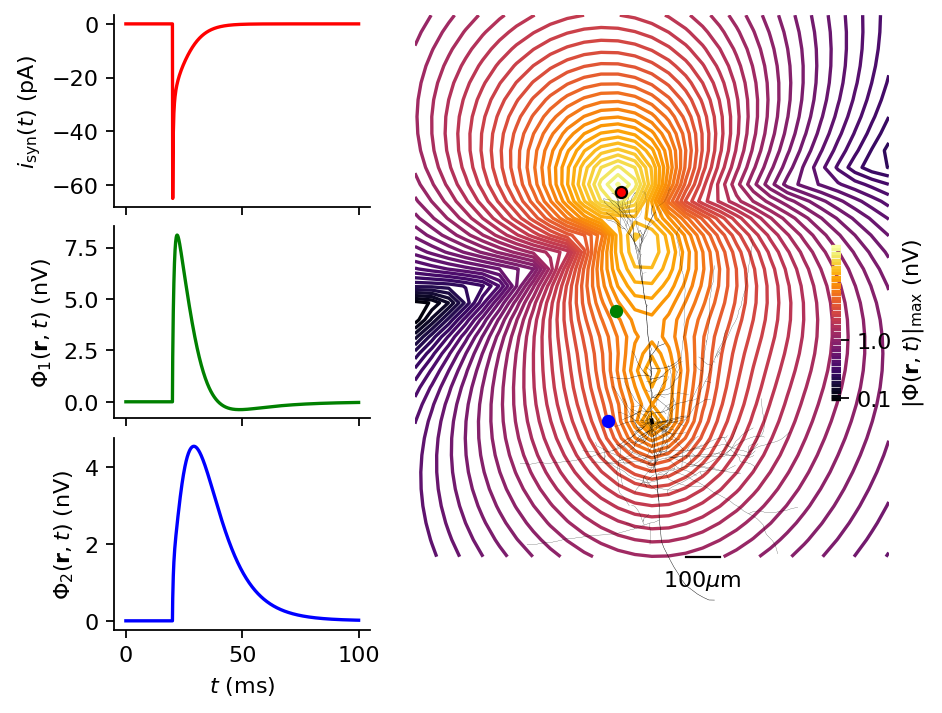

In [10]:
fig = plt.figure(dpi=160)

ax = fig.add_axes([.4,.1,.55,.8], aspect='equal', frameon=False)
cax = fig.add_axes([0.85, 0.4, 0.01, 0.2], frameon=False)

LFP = np.max(np.abs(grid_electrode.LFP),1).reshape(X.shape)
im = ax.contour(X, Z, np.log10(LFP), 
            50,
           cmap='inferno',
           zorder=-2)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('$|\Phi(\mathbf{r}, t)|_\mathrm{max}$ (nV)')
cbar.outline.set_visible(False)
#get some log-linear tickmarks and ticklabels
ticks = np.arange(np.ceil(np.log10(LFP.min())), np.floor(np.log10(LFP.max())))
cbar.set_ticks(ticks)
cbar.set_ticklabels(np.round(10.**ticks * 1E6, decimals=1)) #mV -> nV

#plot morphology
zips = []
for x, z in cell.get_idx_polygons():
    zips.append(list(zip(x, z)))
polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors='k')
ax.add_collection(polycol)

ax.plot([100, 200], [-400, -400], 'k', lw=1, clip_on=False)
ax.text(150, -470, r'100$\mu$m', va='center', ha='center')

ax.axis('off')


ax.plot(synapse.x, synapse.z, 'o', ms=5,
        markeredgecolor='k',
        markerfacecolor='r')

color_vec = ['blue','green']
for i in range(2):
    ax.plot(point_electrode_parameters['x'][i],
                    point_electrode_parameters['z'][i],'o',ms=6,
                    markeredgecolor='none',
                    markerfacecolor=color_vec[i])

plt.axes([.15,.10,.25,.25])
plt.plot(cell.tvec,point_electrode.LFP[0]*1e6,color=color_vec[0], clip_on=False)
plt.ylabel(r'$\Phi_2(\mathbf{r},t)$ (nV)')
plt.xlabel(r'$t$ (ms)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


plt.axes([.15,.375,.25,.25])
plt.plot(cell.tvec,point_electrode.LFP[1]*1e6,color=color_vec[1], clip_on=False)
plt.ylabel(r'$\Phi_1(\mathbf{r}, t)$ (nV)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

plt.axes([.15,.65,.25,.25])
plt.plot(cell.tvec, synapse.i*1E3, color='red', clip_on=False)
plt.ylabel(r'$i_\mathrm{syn}(t)$ (pA)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

# Optionally save figure (uncomment the line below)
# plt.savefig('LFPy-example-03.pdf', dpi=300)